## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi, drawCMS
import CMS_lumi, tdrstyle

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = ['v4','v5']
plot_folder = "v4_vs_v5"
vers = ['v5','v6']
plot_folder = "v5_vs_v6"
vers = ['v4','v5','v6']
plot_folder = "v4_vs_v5_vs_v6"
vers = ['v4','v5','v6','v7','v8','v9']
plot_folder = "v4-v9"
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA
#v6: no event level cuts, clusters made with CA and R parameter 0.6
#v7: cluster CA R=0.5
#v8: cluster CA R=0.8
#v9: cluster CA R=1.0

data_path = {}
data_label = {}
marker_style = {}
line_style = {}
colors = {}
data_label['datav4'] = 'DBSCAN data'
data_label['datav5'] = 'CA data 0.4'
data_label['datav6'] = 'CA data 0.6'
data_label['datav7'] = 'CA data 0.5'
data_label['datav8'] = 'CA data 0.8'
data_label['datav9'] = 'CA data 1.0'
data_label['signalv4'] = 'DBSCAN signal'
data_label['signalv5'] = 'CA signal 0.4'
data_label['signalv6'] = 'CA signal 0.6'
data_label['signalv7'] = 'CA signal 0.5'
data_label['signalv8'] = 'CA signal 0.8'
data_label['signalv9'] = 'CA signal 1.0'

marker_style['datav4'] = 20
marker_style['datav5'] = 24
marker_style['datav6'] = 25
marker_style['datav7'] = 25
marker_style['datav8'] = 25
marker_style['datav9'] = 25
marker_style['signalv4'] = 20
marker_style['signalv5'] = 20
marker_style['signalv6'] = 20
marker_style['signalv7'] = 20
marker_style['signalv8'] = 20
marker_style['signalv9'] = 20

line_style['datav4'] = 1
line_style['datav5'] = 1
line_style['datav6'] = 1
line_style['datav7'] = 1
line_style['datav8'] = 1
line_style['datav9'] = 1
line_style['signalv4'] = 1
line_style['signalv5'] = 2
line_style['signalv6'] = 3
line_style['signalv7'] = 3
line_style['signalv8'] = 3
line_style['signalv9'] = 3
colors['datav4'] = 1
colors['datav5'] = 2
colors['datav6'] = 861
colors['datav7'] = 4
colors['datav8'] = 418
colors['datav9'] = 801
colors['signalv4'] = 1
colors['signalv5'] = 2
colors['signalv6'] = 861
colors['signalv7'] = 4
colors['signalv8'] = 418
colors['signalv9'] = 801

for ve in vers:
    data_path[ve] = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+ve+'/'
lumi = 23.02*1000

if data_year == 2022:
    for ve in vers:
        fpath['data'+ve] = data_path[ve] + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
        fpath['signal'+ve] = data_path[ve] + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    print(k)
    print("Events: ", NEvents[k])
    
for k, T in tree.items():
    branch_names = T.keys()

datav4
Events:  15508012.0
signalv4
Events:  42882900.0
datav5
Events:  15508012.0
signalv5
Events:  42882668.0
datav6
Events:  15508012.0
signalv6
Events:  42882900.0
datav7
Events:  15508012.0
signalv7
Events:  42882900.0
datav8
Events:  15508012.0
signalv8
Events:  42882900.0
datav9
Events:  15508012.0
signalv9
Events:  42882900.0


In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50


intime = True
DPHI_CUT = 1

gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#Trigger paths
HLT_CscCluster_Loose = {}
HLT_CscCluster_Medium = {}
HLT_CscCluster_Tight = {}
HLT_L1CSCShower_DTCluster50 = {}
HLT_L1CSCShower_DTCluster75 = {}


#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpreadWeighted = {}
cscClusterTimeSpread = {}
cscClusterTimeWeighted = {}
cscClusterTimeWeighted2 = {}
cscClusterTimeWeighted3 = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterR = {}
cscClusterZ = {}

cscClusterNStation = {}
cscClusterMaxChamber = {}
cscClusterAvgStation = {}
cscClusterMaxStation = {}

cscClusterNHitMinus13 = {}
cscClusterNHitMinus21 = {}
cscClusterNHitMinus22 = {}
cscClusterNHitMinus31 = {}
cscClusterNHitMinus32 = {}
cscClusterNHitMinus41 = {}
cscClusterNHitMinus42 = {}
cscClusterNHitPlus13 = {}
cscClusterNHitPlus21 = {}
cscClusterNHitPlus22 = {}
cscClusterNHitPlus31 = {}
cscClusterNHitPlus32 = {}
cscClusterNHitPlus41 = {}
cscClusterNHitPlus42 = {}
cscClusterNHit13 = {}
cscClusterNHit21 = {}
cscClusterNHit22 = {}
cscClusterNHit31 = {}
cscClusterNHit32 = {}
cscClusterNHit41 = {}
cscClusterNHit42 = {}



cscClusterDphi = {}
nCscClusters = {}

#Study trigger categories:
cscClusterTimeWeightedTr1 = {}
cscClusterTimeWeightedTr2 = {}
cscClusterTimeWeightedTr3 = {}
cscClusterTimeTr1 = {}
cscClusterTimeTr2 = {}
cscClusterTimeTr3 = {}
cscClusterEtaTr1 = {}
cscClusterEtaTr2 = {}
cscClusterEtaTr3 = {}
cscClusterNStationTr1 = {}
cscClusterNStationTr2 = {}
cscClusterNStationTr3 = {}
cscClusterSizeTr1 = {}
cscClusterSizeTr2 = {}
cscClusterSizeTr3 = {}

#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
nDtClusters = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}


## Settings

I want to decide the category after having filled the vectors

In [4]:
do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True



In [5]:
for k, T in tree.items():
    
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
    
########### SELECTION: CLUSTERS ############

    #CSC
    
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = np.logical_and(sel_csccluster, jet_veto_csc)
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(jet_veto_csc))      

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    

    #ME11 and ME12 veto
    ME11_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto,ME12_veto)
                                   )           

        #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))

    
    #DT

    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)    
    
    
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1

        
    MB1_veto = T.array('dtRechitClusterNHitStation1') == 0
    
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto)                                                                 

    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    
    '''
    sel_dtcluster = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    cut = 5
    station = (T.array('dtRechitClusterNSegStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) 
    '''
   
    
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    #HLT_CaloMET60_DTCluster50 = hlt[:,562]
    #HLT_CaloMET60_DTClusterNoMB1S50 = hlt[:,563]
    #HLT_L1MET_DTCluster50 = hlt[:,564]
    #HLT_L1MET_DTClusterNoMB1S50 = hlt[:,565]
    HLT_CscCluster_Loose[k] = hlt[:,566]
    HLT_CscCluster_Medium[k] = hlt[:,567]
    HLT_CscCluster_Tight[k] = hlt[:,568]
    HLT_L1CSCShower_DTCluster50[k] = hlt[:,569]
    HLT_L1CSCShower_DTCluster75[k] = hlt[:,570]

    #Or of the triggers: to reduce the size
    hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose[k],np.logical_or(HLT_CscCluster_Medium[k],HLT_CscCluster_Tight[k]))
    hlt_sel_ev[k] = np.logical_or(hlt_sel_ev[k],HLT_L1CSCShower_DTCluster50[k])
    hlt_sel_ev[k] = np.logical_or(hlt_sel_ev[k],HLT_L1CSCShower_DTCluster75[k])

    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    #sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #OR of all the HLT paths:
    sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    
    #At least one csc cluster, always required
    sel_ev[k] = np.logical_and(sel_ev[k],sel_csccluster.sum()>=1)
    
    #Data runs with the triggers switched on
    if 'data' in k:
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)
    

    #Categories later!
    '''
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
        #Adding this to avoid overlaps as a starting point
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k]) 
    '''
    
########### BRANCHES ############

    #DT

    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,:]
    
    #CSC
    
    cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]    
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpreadWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxChamber[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxChamber')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxStation[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxStation')[sel_csccluster][sel_ev[k]][:,:]
    
    
    cscClusterNHitMinus13[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus13')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus21[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus21')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus22[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus22')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus31[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus31')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus32[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus32')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus41[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus41')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus42[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus42')[sel_csccluster][sel_ev[k]][:,:]

    cscClusterNHitPlus13[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus13')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus21[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus21')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus22[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus22')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus31[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus31')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus32[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus32')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus41[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus41')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus42[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus42')[sel_csccluster][sel_ev[k]][:,:]
    
    #Global
    
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
               
    sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
    sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        
    #This gives some errors...
    #nMe11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,0]+T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,0]

    #To be fixed, some issues with deltaPhi function
    #deltaRCluster[k] = deltaR(dtRechitClusterEta[k], dtRechitClusterPhi[k],cscRechitClusterEta[k], cscRechitClusterPhi[k])
    #deltaEta[k] = dtRechitClusterEta[k]-cscRechitClusterEta[k]
        


    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))

    #Reduce size
    HLT_CscCluster_Loose[k] = HLT_CscCluster_Loose[k][ sel_ev[k] ]
    HLT_CscCluster_Medium[k] = HLT_CscCluster_Medium[k][ sel_ev[k] ]
    HLT_CscCluster_Tight[k] = HLT_CscCluster_Tight[k][ sel_ev[k] ]
    HLT_L1CSCShower_DTCluster50[k] = HLT_L1CSCShower_DTCluster50[k][ sel_ev[k] ]
    HLT_L1CSCShower_DTCluster75[k] = HLT_L1CSCShower_DTCluster75[k][ sel_ev[k] ]
    
    hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
    sel_ev[k] = sel_ev[k][ sel_ev[k] ]
    print(sel_ev[k].shape)
    print(hlt_sel_ev[k].shape)
    print(HLT_CscCluster_Loose[k].shape)



(13316931,)
(13316931,)
(13316931,)
(90554,)
(90554,)
(90554,)
(13624363,)
(13624363,)
(13624363,)
(91218,)
(91218,)
(91218,)
(12135343,)
(12135343,)
(12135343,)
(86995,)
(86995,)
(86995,)
(12814074,)
(12814074,)
(12814074,)
(89257,)
(89257,)
(89257,)
(10704749,)
(10704749,)
(10704749,)
(81231,)
(81231,)
(81231,)
(8597331,)
(8597331,)
(8597331,)
(74106,)
(74106,)
(74106,)


In [17]:
tree_keys = list(dict.fromkeys(tree_keys))

print("Very loose selections")
for k in tree_keys:
    #if "v4" in k: print("DBSCAN")
    #if "v5" in k: print("CA 0.4")
    #if "v6" in k: print("CA 0.6")
    print(data_label[k])
    print("==0 clusters ", (nCscClusters[k]==0).sum() )
    print("==1 cluster ", (nCscClusters[k]==1).sum() )
    print(">=1 cluster ", (nCscClusters[k]>=1).sum() )
    print("==2 clusters ", (nCscClusters[k]==2).sum() )
    print(">=2 clusters ",  (nCscClusters[k]>=2).sum() )


Very loose selections
DBSCAN data
==0 clusters  0
==1 cluster  13182774
>=1 cluster  13316931
==2 clusters  131967
>=2 clusters  134157
DBSCAN signal
==0 clusters  0
==1 cluster  86881
>=1 cluster  90554
==2 clusters  3664
>=2 clusters  3673
CA data 0.4
==0 clusters  0
==1 cluster  13250647
>=1 cluster  13624363
==2 clusters  362182
>=2 clusters  373716
CA signal 0.4
==0 clusters  0
==1 cluster  86214
>=1 cluster  91218
==2 clusters  4848
>=2 clusters  5004
CA data 0.6
==0 clusters  0
==1 cluster  12003284
>=1 cluster  12135343
==2 clusters  129241
>=2 clusters  132059
CA signal 0.6
==0 clusters  0
==1 cluster  83631
>=1 cluster  86995
==2 clusters  3351
>=2 clusters  3364
CA data 0.5
==0 clusters  0
==1 cluster  12619355
>=1 cluster  12814074
==2 clusters  189746
>=2 clusters  194719
CA signal 0.5
==0 clusters  0
==1 cluster  85489
>=1 cluster  89257
==2 clusters  3733
>=2 clusters  3768
CA data 0.8
==0 clusters  0
==1 cluster  10615739
>=1 cluster  10704749
==2 clusters  87850
>=2 cl

# Category and trigger preselections

In [24]:
category = 0#-1#0
category = 3
#-1: at least 1 csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt,
#3: exactly 2 csc

plot_string = ""
#plot_string+= "_exactly_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto_csc_in_time_cut_time_spread_cut"
#plot_string+= "_at_least_1_csc_cluster_ME_veto_csc_in_time_cut_time_spread_cut"
plot_string+= "_exactly_2_csc_clusters_ME_veto"


category_m1_cut = {}
category_0_cut = {}
category_1_cut = {}
category_2_cut = {}


L1_plateau = {}
HLT_plateau = {}
TRG_plateau = {}
first_fired_HLT = {}
event_cut = {}

sel_trgCluster_tr1 ={}
sel_trgCluster_tr2 ={}
sel_trgCluster_tr3 ={}

first_fired_HLT = {} 
second_fired_HLT = {} 

first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}

first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}


sel_HLT_OR = {}

print(tree_keys)

for k in tree_keys:    
    print(k)
    #Event level
    L1_plateau[k] = ((cscClusterSize[k] >= 200).any()==True)

    if category==2:
        #do DT stuff
        event_cut[k] = np.logical_and(HLT_L1CSCShower_DTCluster50[k]==True,sel_ev[k])
        HLT_plateau[k] = (dtClusterSize[k] >=50).any()==True
    else:
        #do CSC stuff
        event_cut[k] = np.logical_and(HLT_CscCluster_Loose[k]==True,sel_ev[k])
        sel_trgCluster_tr1[k] = np.logical_and( cscClusterSize[k] >= 100, np.logical_and(cscClusterNStation[k]>=2, np.abs(cscClusterEta[k])<1.9))
        sel_trgCluster_tr2[k] = np.logical_and( cscClusterSize[k] >= 200, np.logical_and(cscClusterNStation[k]==1, np.abs(cscClusterEta[k])<1.9))   
        sel_trgCluster_tr3[k] = np.logical_and( cscClusterSize[k] >= 500, np.abs(cscClusterEta[k])>=1.9)

        sel_HLT_OR[k] = np.logical_or(sel_trgCluster_tr1[k],np.logical_or(sel_trgCluster_tr2[k],sel_trgCluster_tr3[k]))
        HLT_plateau[k] = np.logical_or( sel_trgCluster_tr1[k] , np.logical_or(sel_trgCluster_tr2[k],sel_trgCluster_tr3[k])  ).any()==True
      
        
        
    TRG_plateau[k] = np.logical_and( L1_plateau[k], HLT_plateau[k])
    event_cut[k] = np.logical_and(TRG_plateau[k],event_cut[k])
    

    
    #Use the right variable to classify stuff here
    if category == 0:
        event_cut[k]  = np.logical_and(event_cut[k], nCscClusters[k]== 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    elif category == 1:
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] >= 2)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
        #second_fired_HLT[k] = sel_HLT_OR[k][:,1]>0
    elif category == 2:      
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 1)
        event_cut[k]  = np.logical_and(event_cut[k],nDtClusters[k] == 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    elif category == 3:
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 2)
    elif category == -1:      
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] >= 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    
    
    first_in_ME11[k] = (cscClusterR[k][:,0]>100)&(cscClusterR[k][:,0]<275) &(abs(cscClusterZ[k][:,0])>580)&(abs(cscClusterZ[k][:,0])<632) 
    first_in_ME12[k] = (cscClusterR[k][:,0]>275)&(cscClusterR[k][:,0]<465) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)
    first_in_ME13[k] = (cscClusterR[k][:,0]>505)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)

    first_in_ME21[k] = (cscClusterR[k][:,0]>139)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>789)&(abs(cscClusterZ[k][:,0])<850)
    first_in_ME22[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>791)&(abs(cscClusterZ[k][:,0])<850)

    first_in_ME31[k] = (cscClusterR[k][:,0]>160)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>915)&(abs(cscClusterZ[k][:,0])<970)
    first_in_ME32[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>911)&(abs(cscClusterZ[k][:,0])<970)

    first_in_ME41[k] = (cscClusterR[k][:,0]>178)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    first_in_ME42[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    
    first_in_plateau_ME11[k] = first_in_ME11[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME21[k] = first_in_ME21[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME31[k] = first_in_ME31[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME41[k] = first_in_ME41[k] & (cscClusterSize[k][:,0]>=500)

    first_in_plateau_ME12[k] = first_in_ME12[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME13[k] = first_in_ME13[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME22[k] = (first_in_ME22[k]) & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME32[k] = first_in_ME32[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME42[k] = first_in_ME42[k] & (cscClusterSize[k][:,0]>=200)    
    
    first_in_plateau[k] = first_in_plateau_ME11[k] | first_in_plateau_ME12[k] | first_in_plateau_ME13[k] | first_in_plateau_ME21[k] | first_in_plateau_ME22[k] | first_in_plateau_ME31[k] | first_in_plateau_ME32[k] | first_in_plateau_ME41[k] | first_in_plateau_ME42[k]

    
    print(sel_HLT_OR[k].shape)
    print(sel_HLT_OR[k][:,:])
    
    ###FIX: some sel HLT OR have zero entries, check why
    
    #print(HLT_plateau[k].shape)
    #print(sel_ev[k].shape)
    #print(cscClusterSize[k].shape)
    #print(nCscClusters[k])

['datav4', 'signalv4', 'datav5', 'signalv5', 'datav6', 'signalv6', 'datav7', 'signalv7', 'datav8', 'signalv8', 'datav9', 'signalv9']
datav4
(13316931,)
[[True] [True] [True] ... [True] [True] [True]]
signalv4
(90554,)
[[True] [True] [False] ... [True] [True] [True]]
datav5
(13624363,)
[[True] [True] [True] ... [True] [True] [True]]
signalv5
(91218,)
[[True] [True True] [False] ... [True] [True] [True]]
datav6
(12135343,)
[[True] [True] [True] ... [False] [True] [True]]
signalv6
(86995,)
[[True] [True] [False] ... [True] [True] [True]]
datav7
(12814074,)
[[True] [True] [True] ... [True] [True] [True]]
signalv7
(89257,)
[[True] [True] [False] ... [True] [True] [True]]
datav8
(10704749,)
[[True] [True] [True] ... [True] [True] [True]]
signalv8
(81231,)
[[True] [True] [False] ... [True] [True] [True]]
datav9
(8597331,)
[[True] [True] [True] ... [True] [True] [True]]
signalv9
(74106,)
[[True] [False] [True] ... [True] [True] [True]]


Check when we get a dramatic difference in the number of events!!!

In [25]:
print("Category selections")
for k in tree_keys:
    #if "v4" in k: print("DBSCAN")
    #if "v5" in k: print("CA 0.4")
    #if "v6" in k: print("CA 0.6")
    print(data_label[k])
    print("==0 clusters ", (nCscClusters[k][event_cut[k]]==0).sum() )
    print("==1 cluster ", (nCscClusters[k][event_cut[k]]==1).sum() )
    #print(">=1 cluster ", (nCscClusters[k][event_cut[k]]>=1).sum() )
    print("==2 clusters ", (nCscClusters[k][event_cut[k]]==2).sum() )
    #print(">=2 clusters ",  (nCscClusters[k][event_cut[k]]>=2).sum() )

Category selections
DBSCAN data
==0 clusters  0
==1 cluster  0
==2 clusters  90512
DBSCAN signal
==0 clusters  0
==1 cluster  0
==2 clusters  3435
CA data 0.4
==0 clusters  0
==1 cluster  0
==2 clusters  291288
CA signal 0.4
==0 clusters  0
==1 cluster  0
==2 clusters  4610
CA data 0.6
==0 clusters  0
==1 cluster  0
==2 clusters  88084
CA signal 0.6
==0 clusters  0
==1 cluster  0
==2 clusters  3129
CA data 0.5
==0 clusters  0
==1 cluster  0
==2 clusters  141269
CA signal 0.5
==0 clusters  0
==1 cluster  0
==2 clusters  3502
CA data 0.8
==0 clusters  0
==1 cluster  0
==2 clusters  57700
CA signal 0.8
==0 clusters  0
==1 cluster  0
==2 clusters  2671
CA data 1.0
==0 clusters  0
==1 cluster  0
==2 clusters  36774
CA signal 1.0
==0 clusters  0
==1 cluster  0
==2 clusters  2224


## General histograms

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

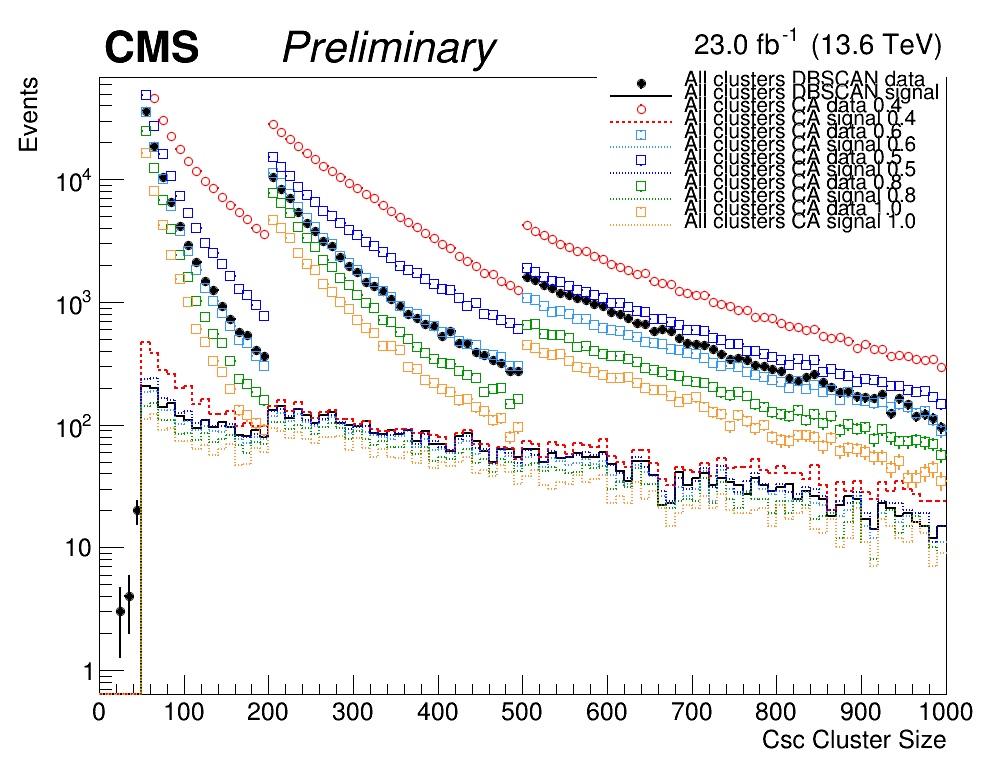

In [26]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.7,0.95,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:

        
    tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] ]    
    h0[k] = create_TH1D(tmp_cscClusterSize[:,:].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"All clusters "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

        
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize_all"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize_all"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

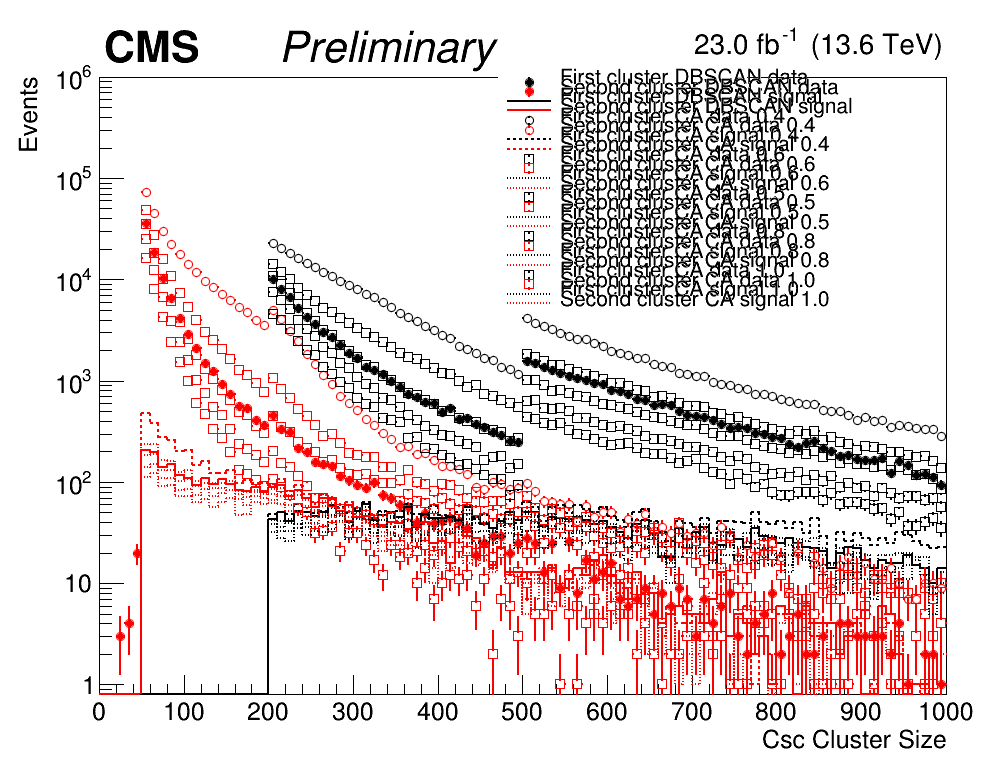

In [27]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:

        
    tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] ]    
    h0[k] = create_TH1D(tmp_cscClusterSize[:,0].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h1[k] = create_TH1D(tmp_cscClusterSize[:,1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    #h2[k].Draw('PE same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

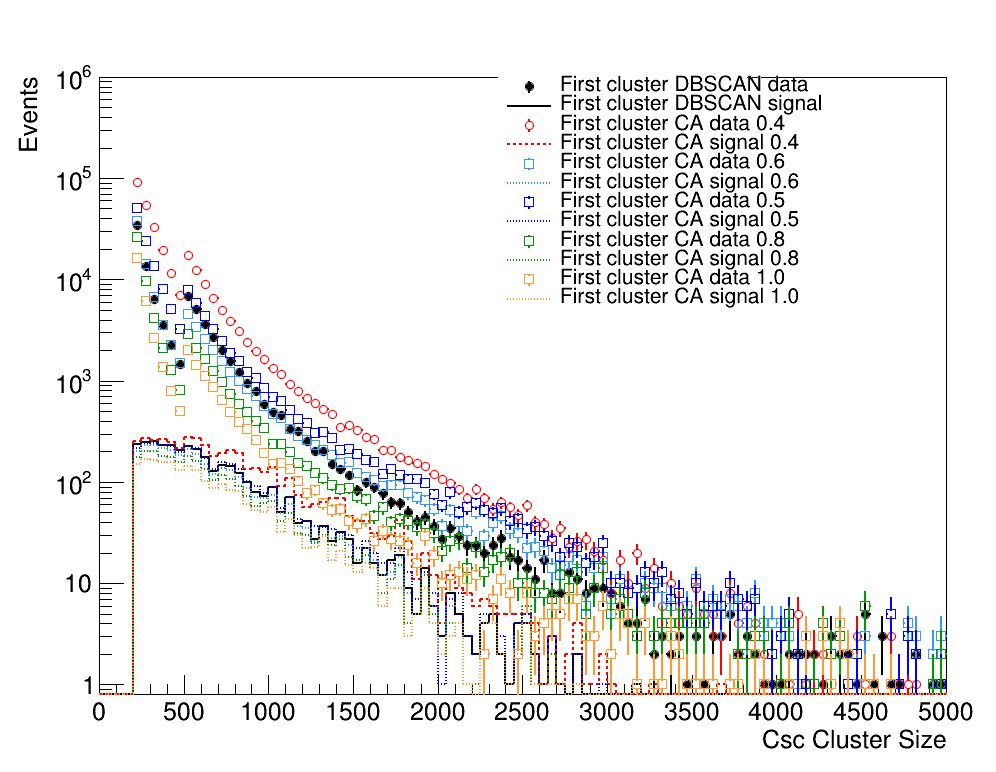

In [28]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterSize[:,0].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,5000])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

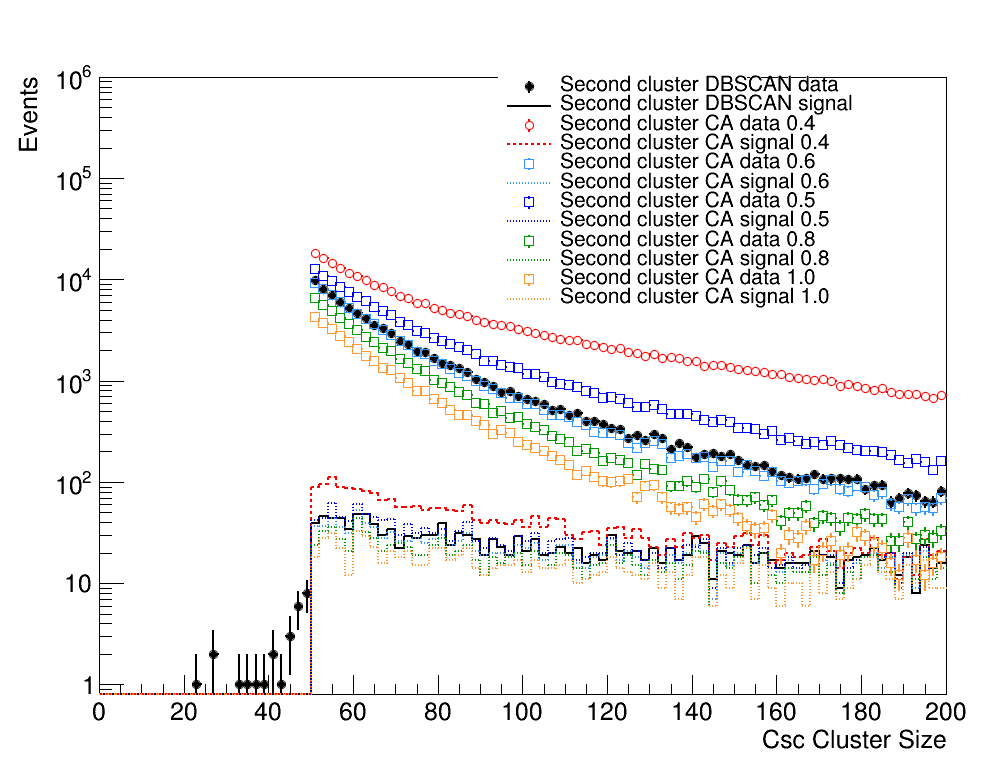

In [29]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h0[k] = create_TH1D(tmp_cscClusterSize[:,1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,200])
    leg.AddEntry(h0[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize"+plot_string+".png")

### Clusters in different HLT categories

* First cluster fires L1 (200 hits)
* First cluster fires OR of triggers
* First cluster fires each specific HLT region

TODO

In [30]:
first_fired_L1 = {}
first_fired_HLT = {} 
first_fired_HLT_tr1 = {}
first_fired_HLT_tr2 = {}
first_fired_HLT_tr3 = {}
cscClusterSize_0_HLT = {}
cscClusterSize_0_HLT_tr1 = {}
cscClusterSize_0_HLT_tr2 = {}
cscClusterSize_0_HLT_tr3 = {}
cscClusterSize_1_HLT = {}
cscClusterSize_1_HLT_tr1 = {}
cscClusterSize_1_HLT_tr2 = {}
cscClusterSize_1_HLT_tr3 = {}


cscClusterAvgStation_0_HLT = {}
cscClusterAvgStation_0_HLT_tr1 = {}
cscClusterAvgStation_0_HLT_tr2 = {}
cscClusterAvgStation_0_HLT_tr3 = {}

cscClusterAvgStation_1_HLT = {}
cscClusterAvgStation_1_HLT_tr1 = {}
cscClusterAvgStation_1_HLT_tr2 = {}
cscClusterAvgStation_1_HLT_tr3 = {}

cscClusterMaxStation_0_HLT = {}
cscClusterMaxStation_0_HLT_tr1 = {}
cscClusterMaxStation_0_HLT_tr2 = {}
cscClusterMaxStation_0_HLT_tr3 = {}

cscClusterMaxStation_1_HLT = {}
cscClusterMaxStation_1_HLT_tr1 = {}
cscClusterMaxStation_1_HLT_tr2 = {}
cscClusterMaxStation_1_HLT_tr3 = {}


cscClusterMaxChamber_0_HLT = {}
cscClusterMaxChamber_0_HLT_tr1 = {}
cscClusterMaxChamber_0_HLT_tr2 = {}
cscClusterMaxChamber_0_HLT_tr3 = {}

cscClusterMaxChamber_1_HLT = {}
cscClusterMaxChamber_1_HLT_tr1 = {}
cscClusterMaxChamber_1_HLT_tr2 = {}
cscClusterMaxChamber_1_HLT_tr3 = {}

for k in tree_keys:    
    print(k)
    sub_sel = np.logical_and(event_cut[k],nCscClusters[k]==2)
    first_fired_L1[k] = cscClusterSize[k][ sub_sel ][:,0]>=200
    first_fired_HLT[k] = np.logical_and(sel_HLT_OR[k][ sub_sel ][:,0]>0,first_fired_L1[k])
    first_fired_HLT_tr1[k] = np.logical_and(sel_trgCluster_tr1[k][ sub_sel ][:,0]>0,first_fired_L1[k])
    first_fired_HLT_tr2[k] = np.logical_and(sel_trgCluster_tr2[k][ sub_sel ][:,0]>0,first_fired_L1[k])
    first_fired_HLT_tr3[k] = np.logical_and(sel_trgCluster_tr3[k][ sub_sel ][:,0]>0,first_fired_L1[k])
    

    cscClusterSize_0_HLT[k] = cscClusterSize[k][sub_sel][first_fired_HLT[k]][:,0]
    cscClusterSize_0_HLT_tr1[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr1[k]][:,0]
    cscClusterSize_0_HLT_tr2[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr2[k]][:,0]
    cscClusterSize_0_HLT_tr3[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr3[k]][:,0]
    cscClusterSize_1_HLT[k] = cscClusterSize[k][sub_sel][first_fired_HLT[k]][:,1]
    cscClusterSize_1_HLT_tr1[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr1[k]][:,1]
    cscClusterSize_1_HLT_tr2[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr2[k]][:,1]
    cscClusterSize_1_HLT_tr3[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr3[k]][:,1]
    
    
    cscClusterAvgStation_0_HLT[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT[k]][:,0]
    cscClusterAvgStation_0_HLT_tr1[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr1[k]][:,0]
    cscClusterAvgStation_0_HLT_tr2[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr2[k]][:,0]
    cscClusterAvgStation_0_HLT_tr3[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr3[k]][:,0]
    cscClusterAvgStation_1_HLT[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT[k]][:,1]
    cscClusterAvgStation_1_HLT_tr1[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr1[k]][:,1]
    cscClusterAvgStation_1_HLT_tr2[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr2[k]][:,1]
    cscClusterAvgStation_1_HLT_tr3[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr3[k]][:,1]
    
    cscClusterMaxStation_0_HLT[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT[k]][:,0]
    cscClusterMaxStation_0_HLT_tr1[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr1[k]][:,0]
    cscClusterMaxStation_0_HLT_tr2[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr2[k]][:,0]
    cscClusterMaxStation_0_HLT_tr3[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr3[k]][:,0]
    cscClusterMaxStation_1_HLT[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT[k]][:,1]
    cscClusterMaxStation_1_HLT_tr1[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr1[k]][:,1]
    cscClusterMaxStation_1_HLT_tr2[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr2[k]][:,1]
    cscClusterMaxStation_1_HLT_tr3[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr3[k]][:,1]
    
    cscClusterMaxChamber_0_HLT[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT[k]][:,0]
    cscClusterMaxChamber_0_HLT_tr1[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr1[k]][:,0]
    cscClusterMaxChamber_0_HLT_tr2[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr2[k]][:,0]
    cscClusterMaxChamber_0_HLT_tr3[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr3[k]][:,0]
    cscClusterMaxChamber_1_HLT[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT[k]][:,1]
    cscClusterMaxChamber_1_HLT_tr1[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr1[k]][:,1]
    cscClusterMaxChamber_1_HLT_tr2[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr2[k]][:,1]
    cscClusterMaxChamber_1_HLT_tr3[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr3[k]][:,1]


datav4
signalv4
datav5
signalv5
datav6
signalv6
datav7
signalv7
datav8
signalv8
datav9
signalv9


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potenti

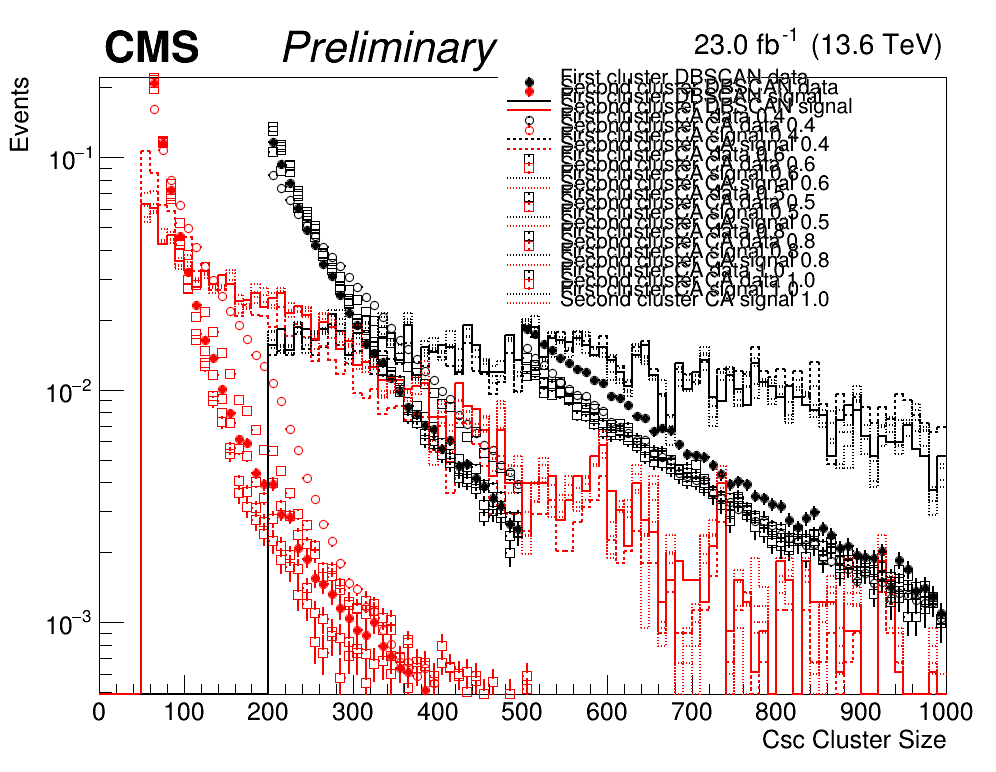

In [31]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:

        
    tmp_cscClusterSize = cscClusterSize_0_HLT[k]    
    h0[k] = create_TH1D(tmp_cscClusterSize.flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterSize = cscClusterSize_1_HLT[k]
    h1[k] = create_TH1D(tmp_cscClusterSize.flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize_first_fires_HLT"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize_first_fires_HLT"+plot_string+".png")

### First/second cluster in different HLT categories

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

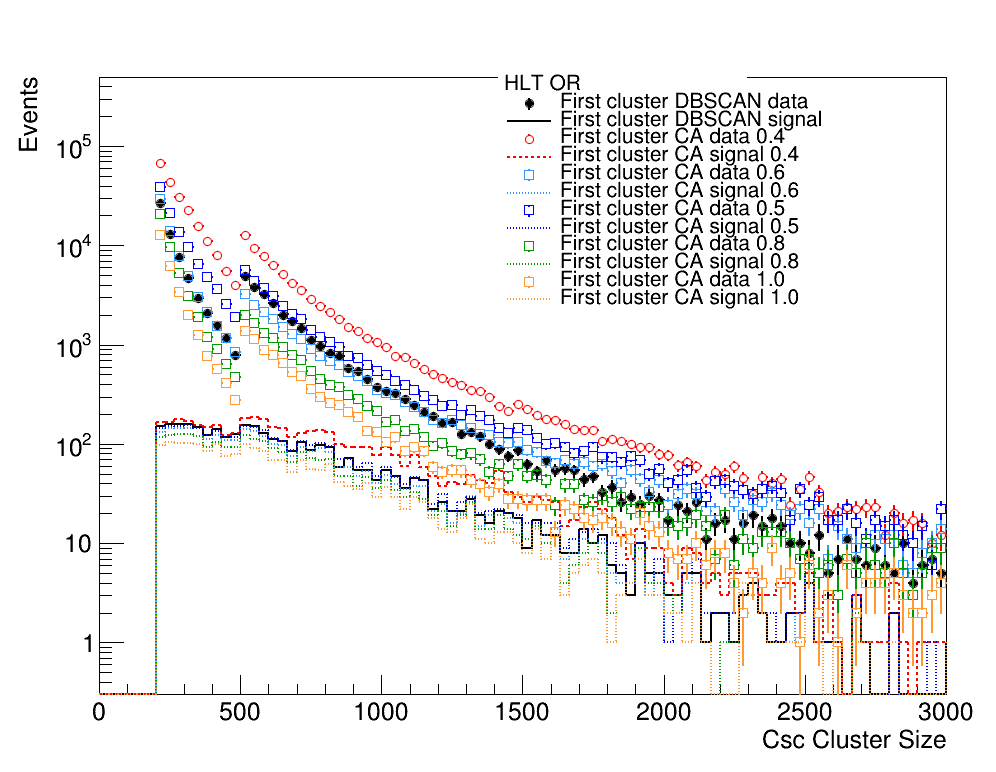

In [32]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}


cat_lab = "HLT_OR"
#cat_lab = "HLT_1"
#cat_lab = "HLT_2"
#cat_lab = "HLT_3"


cat_lab_dict = {}
cat_lab_dict["HLT_OR"] = "HLT OR"
cat_lab_dict["HLT_1"] = "HLT |#eta|<1.9, #geq 2 stations, 100 hits"
cat_lab_dict["HLT_2"] = "HLT |#eta|<1.9, 1 station, 200 hits"
cat_lab_dict["HLT_3"] = "HLT |#eta| #leq 1.9, 500 hits"
leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if cat_lab=="HLT_OR":
        tmp_cscClusterSize = cscClusterSize_0_HLT[k] 
    elif cat_lab=="HLT_1":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr2[k] 
    elif cat_lab=="HLT_3":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr3[k] 
    h0[k] = create_TH1D(tmp_cscClusterSize.flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[90,0,3000])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(5.e5)
    h0[k].SetMinimum(0.3)
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

### Look at the station

TODO

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

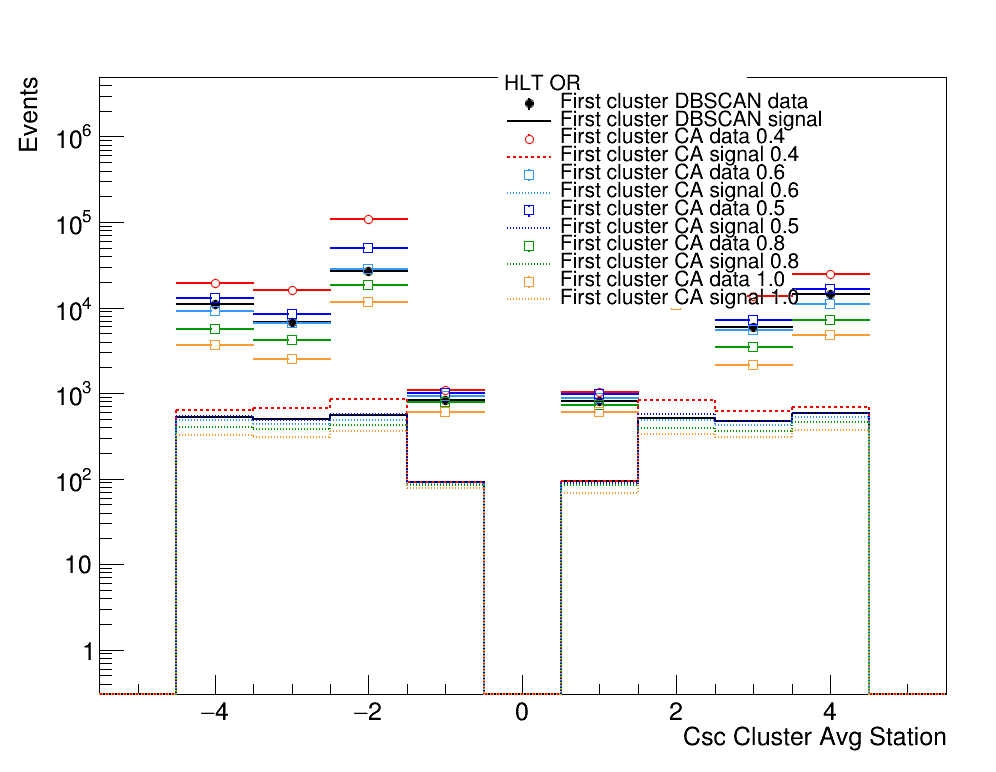

In [33]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}


leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if cat_lab=="HLT_OR":
        tmp_var = cscClusterAvgStation_0_HLT[k] 
    elif cat_lab=="HLT_1":
        tmp_var = cscClusterAvgStation_0_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_var = cscClusterAvgStation_0_HLT_tr2[k] 
    elif cat_lab=="HLT_3":
        tmp_var = cscClusterAvgStation_0_HLT_tr3[k] 
    h0[k] = create_TH1D(tmp_var.flatten(),title="",axis_title = ['Csc Cluster Avg Station','Events'], binning=[11,-5-0.5,6-0.5])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(5.e6)
    h0[k].SetMinimum(0.3)
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterAvgStation_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterAvgStation_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potenti

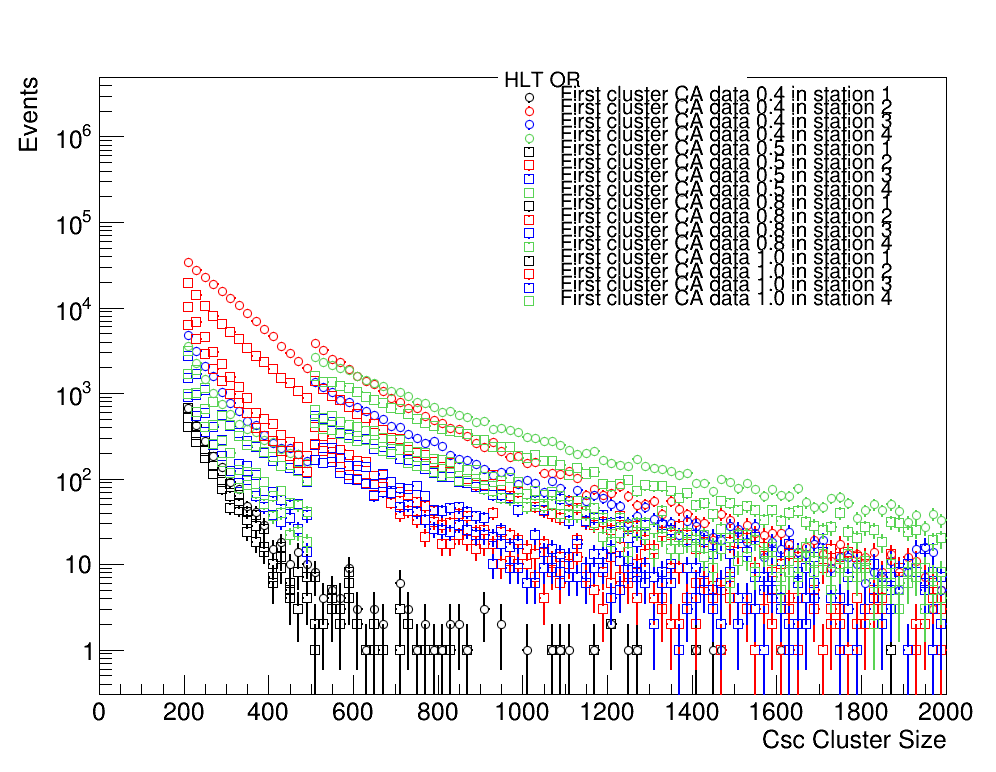

In [34]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}

leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if "signal" in k: continue
    if "v4" in k: continue
    if "v6" in k: continue
    if cat_lab=="HLT_OR":
        tmp_sel = cscClusterMaxStation_0_HLT[k]
        tmp_var = cscClusterSize_0_HLT[k]
    elif cat_lab=="HLT_1":
        tmp_sel = cscClusterMaxStation_0_HLT_tr1[k]
        tmp_var = cscClusterSize_0_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_sel = cscClusterMaxStation_0_HLT_tr2[k] 
        tmp_var = cscClusterSize_0_HLT_tr2[k]
    elif cat_lab=="HLT_3":
        tmp_sel = cscClusterMaxStation_0_HLT_tr3[k] 
        tmp_var = cscClusterSize_0_HLT_tr3[k]
        
    h1[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,2000])
    leg.AddEntry(h1[k],"First cluster "+data_label[k]+" in station 1",'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(1)#(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(1)#(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h1[k].SetMaximum(5.e6)
    h1[k].SetMinimum(0.3)
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')

    h2[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,2000])
    leg.AddEntry(h2[k],"First cluster "+data_label[k]+" in station 2",'PE' if 'data' in k else 'L')
    h2[k].SetLineColor(2)#(colors[k])
    h2[k].SetLineWidth(2)
    h2[k].SetLineStyle(line_style[k])
    h2[k].SetMarkerColor(2)#(colors[k])
    h2[k].SetMarkerStyle(marker_style[k])
    h2[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h2[k].SetMaximum(5.e6)
    h2[k].SetMinimum(0.3)
    h2[k].Draw('PE same' if 'data' in k else 'HISTO same')    

    h3[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==3].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,2000])
    leg.AddEntry(h3[k],"First cluster "+data_label[k]+" in station 3",'PE' if 'data' in k else 'L')
    h3[k].SetLineColor(4)#(colors[k])
    h3[k].SetLineWidth(2)
    h3[k].SetLineStyle(line_style[k])
    h3[k].SetMarkerColor(4)#(colors[k])
    h3[k].SetMarkerStyle(marker_style[k])
    h3[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h3[k].SetMaximum(5.e6)
    h3[k].SetMinimum(0.3)
    h3[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
    h4[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==4].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,2000])
    leg.AddEntry(h4[k],"First cluster "+data_label[k]+" in station 4",'PE' if 'data' in k else 'L')
    h4[k].SetLineColor(8)#(colors[k])
    h4[k].SetLineWidth(2)
    h4[k].SetLineStyle(line_style[k])
    h4[k].SetMarkerColor(8)#(colors[k])
    h4[k].SetMarkerStyle(marker_style[k])
    h4[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h4[k].SetMaximum(5.e6)
    h4[k].SetMinimum(0.3)
    h4[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potenti

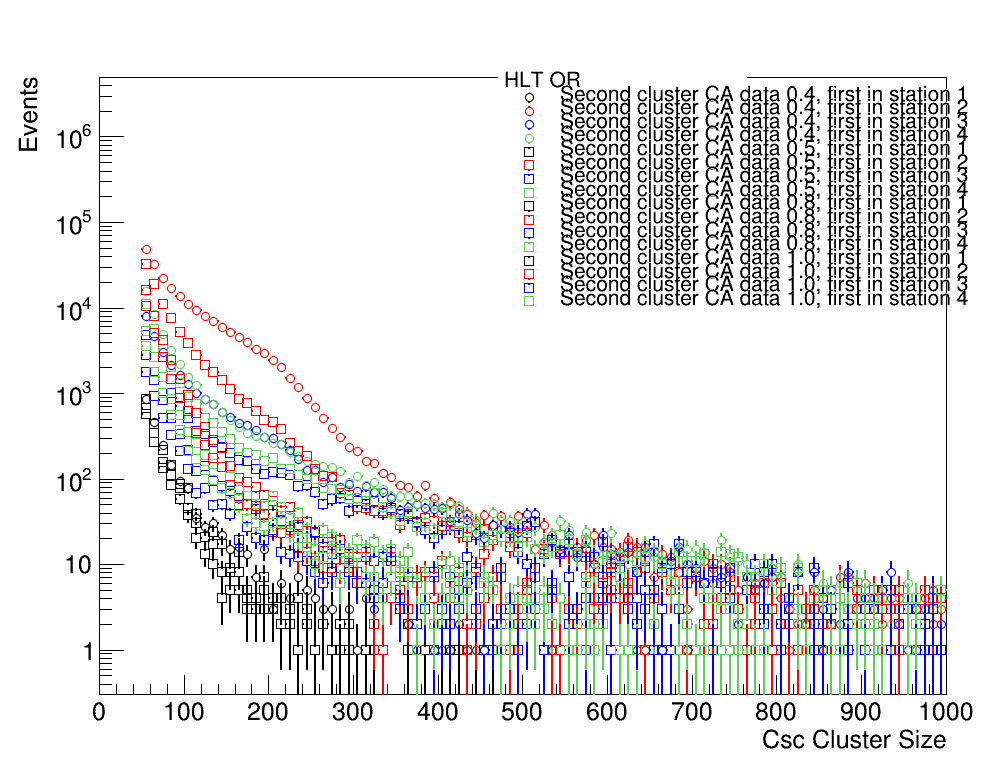

In [35]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}

leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if "signal" in k: continue
    if "v4" in k: continue
    if "v6" in k: continue
    if cat_lab=="HLT_OR":
        tmp_sel = cscClusterMaxStation_0_HLT[k]
        tmp_var = cscClusterSize_1_HLT[k]
    elif cat_lab=="HLT_1":
        tmp_sel = cscClusterMaxStation_0_HLT_tr1[k]
        tmp_var = cscClusterSize_1_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_sel = cscClusterMaxStation_0_HLT_tr2[k] 
        tmp_var = cscClusterSize_1_HLT_tr2[k]
    elif cat_lab=="HLT_3":
        tmp_sel = cscClusterMaxStation_0_HLT_tr3[k] 
        tmp_var = cscClusterSize_1_HLT_tr3[k]
        
    h1[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k]+", first in station 1",'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(1)#(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(1)#(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h1[k].SetMaximum(5.e6)
    h1[k].SetMinimum(0.3)
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')

    h2[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h2[k],"Second cluster "+data_label[k]+", first in station 2",'PE' if 'data' in k else 'L')
    h2[k].SetLineColor(2)#(colors[k])
    h2[k].SetLineWidth(2)
    h2[k].SetLineStyle(line_style[k])
    h2[k].SetMarkerColor(2)#(colors[k])
    h2[k].SetMarkerStyle(marker_style[k])
    h2[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h2[k].SetMaximum(5.e6)
    h2[k].SetMinimum(0.3)
    h2[k].Draw('PE same' if 'data' in k else 'HISTO same')    

    h3[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==3].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h3[k],"Second cluster "+data_label[k]+", first in station 3",'PE' if 'data' in k else 'L')
    h3[k].SetLineColor(4)#(colors[k])
    h3[k].SetLineWidth(2)
    h3[k].SetLineStyle(line_style[k])
    h3[k].SetMarkerColor(4)#(colors[k])
    h3[k].SetMarkerStyle(marker_style[k])
    h3[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h3[k].SetMaximum(5.e6)
    h3[k].SetMinimum(0.3)
    h3[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
    h4[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==4].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h4[k],"Second cluster "+data_label[k]+", first in station 4",'PE' if 'data' in k else 'L')
    h4[k].SetLineColor(8)#(colors[k])
    h4[k].SetLineWidth(2)
    h4[k].SetLineStyle(line_style[k])
    h4[k].SetMarkerColor(8)#(colors[k])
    h4[k].SetMarkerStyle(marker_style[k])
    h4[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h4[k].SetMaximum(5.e6)
    h4[k].SetMinimum(0.3)
    h4[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

In [36]:
for b in branch_names:
    if 'cscRechitCluster' in str(b):
        print(b)

b'cscRechitCluster_match_gLLP'
b'cscRechitCluster_match_gLLP_minDeltaR'
b'cscRechitCluster_match_gLLP_index'
b'cscRechitCluster_match_gLLP_eta'
b'cscRechitCluster_match_gLLP_phi'
b'cscRechitCluster_match_gLLP_decay_r'
b'cscRechitCluster_match_gLLP_decay_z'
b'cscRechitCluster_match_gLLP_csc'
b'cscRechitCluster_match_gLLP_dt'
b'cscRechitCluster_match_gLLP_e'
b'cscRechitClusterX'
b'cscRechitClusterY'
b'cscRechitClusterZ'
b'cscRechitClusterTimeWeighted'
b'cscRechitClusterTimeSpreadWeightedAll'
b'cscRechitClusterTime'
b'cscRechitClusterTimeSpread'
b'cscRechitClusterPhi'
b'cscRechitClusterEta'
b'cscRechitClusterJetVetoPt'
b'cscRechitClusterJetVetoLooseId'
b'cscRechitClusterJetVetoTightId'
b'cscRechitClusterJetVetoE'
b'cscRechitClusterMuonVetoPt'
b'cscRechitClusterMuonVetoE'
b'cscRechitClusterMuonVetoLooseId'
b'cscRechitClusterMuonVetoGlobal'
b'cscRechitCluster_match_dtSeg_0p4'
b'cscRechitCluster_match_MB1Seg_0p4'
b'cscRechitCluster_match_RE12_0p4'
b'cscRechitCluster_match_RB1_0p4'
b'cscRechi

Calculate signal/background level for second cluster, v4 vs v5

### Delta R between first and second cluster

{'datav4': array([ True,  True,  True, ...,  True, False, False]), 'signalv4': array([False,  True, False, ...,  True, False, False]), 'datav5': array([ True,  True,  True, ...,  True, False, False]), 'signalv5': array([False, False, False, ...,  True, False, False]), 'datav6': array([ True,  True,  True, ..., False,  True, False]), 'signalv6': array([False,  True, False, ...,  True, False, False]), 'datav7': array([ True,  True,  True, ...,  True, False, False]), 'signalv7': array([False,  True, False, ...,  True, False, False]), 'datav8': array([ True,  True,  True, ..., False,  True, False]), 'signalv8': array([False,  True, False, ...,  True, False, False]), 'datav9': array([ True,  True,  True, ..., False,  True, False]), 'signalv9': array([False, False,  True, ...,  True, False, False])}
datav4
signalv4
datav5


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

signalv5
datav6
signalv6
datav7
signalv7
datav8


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

signalv8
datav9
signalv9
DBSCAN: S 2258, B 77258, S/B 0.0292, S/sqrt(B) 8.12 
CA 0.6: S 2078, B 76672, S/B 0.0271, S/sqrt(B) 7.50 
CA 0.4: S 2928, B 139489, S/B 0.0210, S/sqrt(B) 7.84 
CA 0.5: S 2297, B 97383, S/B 0.0236, S/sqrt(B) 7.36 
CA 0.8: S 1780, B 52078, S/B 0.0342, S/sqrt(B) 7.80 
CA 1.0: S 1467, B 32982, S/B 0.0445, S/sqrt(B) 8.08 


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

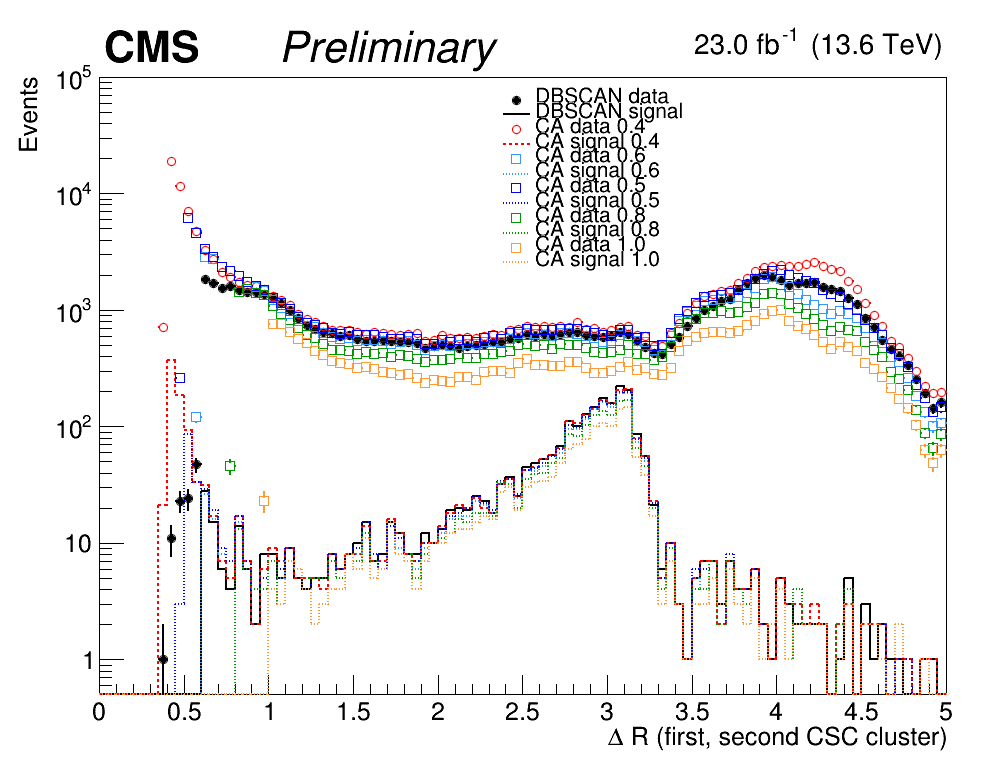

In [41]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.65,0.65,0.88)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()

print(first_in_plateau)
nevents_passing = {}
for k in tree_keys:
    print(k)
    tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
    tmp_cscClusterEta = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
    tmp_cscClusterPhi = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) & first_in_plateau[k] ]
    #tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  ]
    #tmp_cscClusterEta = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) ]
    #tmp_cscClusterPhi = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  ]
    #print( deltaR(tmp_cscClusterEta[:,0].flatten(), tmp_cscClusterPhi[:,0].flatten(), tmp_cscClusterEta[:,1].flatten(), tmp_cscClusterPhi[:,1].flatten()) )
    tmp_dR = deltaR(tmp_cscClusterEta[:,0].flatten(), tmp_cscClusterPhi[:,0].flatten(), tmp_cscClusterEta[:,1].flatten(), tmp_cscClusterPhi[:,1].flatten())
    #print( (p1 - p2 + np.pi) % (2 * np.pi) - np.pi )

    
    h1[k] = create_TH1D(tmp_dR,title="",axis_title = ['#Delta R (first, second CSC cluster)','Events'], binning=[100,0,5])
    leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h1[k].SetMaximum(1.e05)

    nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2)  & first_in_plateau[k]  ].sum()
    
leg.Draw()
can.SetRightMargin(0.05)


print("DBSCAN: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv4'], nevents_passing['datav4'], float(nevents_passing['signalv4'])/float(nevents_passing['datav4']), float(nevents_passing['signalv4'])/float(math.sqrt(nevents_passing['datav4'])) ) )
print("CA 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv6'], nevents_passing['datav6'], float(nevents_passing['signalv6'])/float(nevents_passing['datav6']), float(nevents_passing['signalv6'])/float(math.sqrt(nevents_passing['datav6'])) ) )
print("CA 0.4: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv5'], nevents_passing['datav5'], float(nevents_passing['signalv5'])/float(nevents_passing['datav5']), float(nevents_passing['signalv5'])/float(math.sqrt(nevents_passing['datav5'])) ) )
print("CA 0.5: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv7'], nevents_passing['datav7'], float(nevents_passing['signalv7'])/float(nevents_passing['datav7']), float(nevents_passing['signalv7'])/float(math.sqrt(nevents_passing['datav7'])) ) )
print("CA 0.8: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv8'], nevents_passing['datav8'], float(nevents_passing['signalv8'])/float(nevents_passing['datav8']), float(nevents_passing['signalv8'])/float(math.sqrt(nevents_passing['datav8'])) ) )
print("CA 1.0: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv9'], nevents_passing['datav9'], float(nevents_passing['signalv9'])/float(nevents_passing['datav9']), float(nevents_passing['signalv9'])/float(math.sqrt(nevents_passing['datav9'])) ) )



# if setlog: 
can.SetLogy()
can.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.Print("plots/V1p19_"+plot_folder+"/DeltaR_csc_clusters"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/DeltaR_csc_clusters"+plot_string+".png")
#can.Close()

### Delta R in different HLT categories

# Todo list

* Look at different endcaps in the plot for csc time and n station
* Look at clusters associated with a muon, do they have the double peak?
* Look at clusters associated with a jet, double peak?
* Does the time spread cut remove the second peak?
* Study v4
* Study v5 --> some small amount of events with less than 50 hits in dbscan
* Study what happens with L1 and HLT conditions and more than 1 CSC cluster
* Study DT turn on